In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transfuse_till_epoch_80/pytorch/default/1/checkpoint_1.pth
/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/20191026T195815_539_mask.png
/kaggle/input/unetdata/TN_images/TN_images/01580PSFHSAoP4k_1580.png
/kaggle/input/unetdata/test_Masks/test_Masks/00844_PSFHAoP4k_mask.png
/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane/20191115T105730_719.png
/kaggle/input/transfuse_till_epoch_150/pytorch/default/1/checkpoint_1.pth


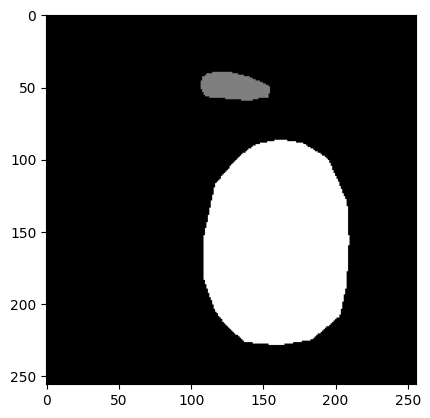

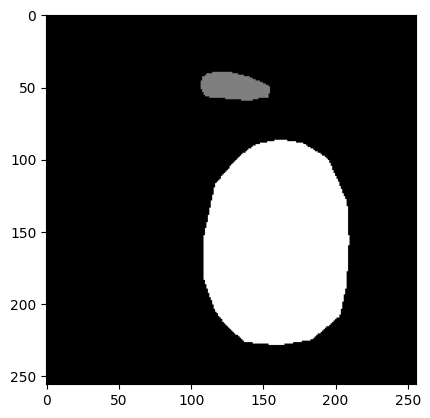

In [2]:
import cv2
import matplotlib.pyplot as plt
mask1 = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)

mask = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)  
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       #  detects boundaries
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)      # draws boundary on an image


img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane',
    target_path='/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks',
    transform=transform,
    target_transform=transform1
)

test_dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/TN_images/TN_images',
    target_path='/kaggle/input/unetdata/test_Masks/test_Masks',
    transform=transform,
    target_transform=transform1
)

# Check the number of images
img_path = '/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane'
print(len(os.listdir(img_path)))

target_path = '/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks'
print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/unetdata/TN_images/TN_images'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/unetdata/test_Masks/test_Masks'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7584
7584
1414
1414


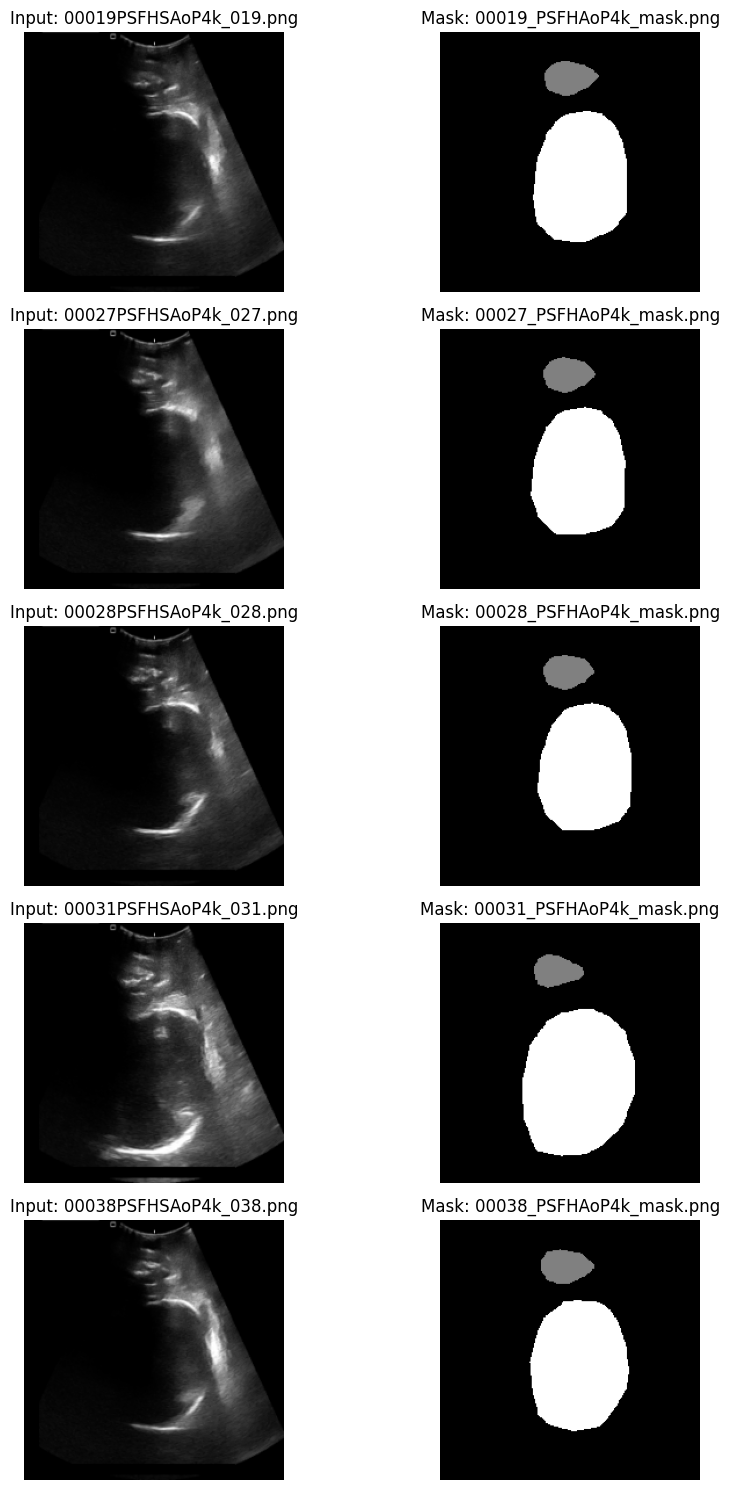

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import torch.nn.functional as F
import numpy as np
import math
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from functools import partial
from timm.models.registry import register_model
# from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1, num_classes=3, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
# def vit_small_patch16_224(pretrained=False, **kwargs):
#     if pretrained:
#         # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
#         kwargs.setdefault('qk_scale', 768 ** -0.5)
#     model = VisionTransformer(patch_size=16, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
#     model.default_cfg = default_cfgs['vit_small_patch16_224']
#     if pretrained:
#         load_pretrained(
#             model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
#     return model



# __all__ = [
#      'deit_small_patch16_224',
# ]


# class DeiT(VisionTransformer):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         num_patches = self.patch_embed.num_patches
#         self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))

#     def forward(self, x):
#         # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
#         # with slight modifications to add the dist_token
#         B = x.shape[0]
#         x = self.patch_embed(x)
#         pe = self.pos_embed

#         x = x + pe
#         x = self.pos_drop(x)

#         for blk in self.blocks:
#             x = blk(x)

#         x = self.norm(x)
#         return x


@register_model
# def deit_small_patch16_224(pretrained=False, **kwargs):
#     model = DeiT(
#         patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
#         norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
#     # if pretrained:
#     #     ckpt = torch.load('pretrained/deit_small_patch16_224-cd65a155.pth')
#     #     model.load_state_dict(ckpt['model'], strict=False)
    
#     pe = model.pos_embed[:, 1:, :].detach()
#     pe = pe.transpose(-1, -2)
#     pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
#     pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
#     pe = pe.flatten(2)
#     pe = pe.transpose(-1, -2)
#     model.pos_embed = nn.Parameter(pe)
#     model.head = nn.Identity()
#     return model
# def deit_small_patch16_224(pretrained=False, **kwargs):
#     model = DeiT(
#         patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
#         norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    
#     # Adjust the positional embedding interpolation
#     num_patches = model.patch_embed.num_patches
#     num_tokens = 1  # for cls token
#     old_pos_embed = model.pos_embed
    
#     # Interpolate positional embeddings
#     if old_pos_embed.shape[1] != num_patches + num_tokens:
#         # Remove cls token and reshape
#         pos_embed = old_pos_embed[:, num_tokens:, :].reshape(1, int(np.sqrt(num_patches)), int(np.sqrt(num_patches)), -1).permute(0, 3, 1, 2)
        
#         # Interpolate to match new patch grid size
#         pos_embed = F.interpolate(pos_embed, size=(12, 16), mode='bilinear', align_corners=False)
        
#         # Reshape back and add cls token
#         pos_embed = pos_embed.permute(0, 2, 3, 1).reshape(1, 12*16, -1)
#         new_pos_embed = torch.zeros_like(old_pos_embed)
#         new_pos_embed[:, 0:1, :] = old_pos_embed[:, 0:1, :]
#         new_pos_embed[:, 1:, :] = pos_embed
        
#         model.pos_embed = nn.Parameter(new_pos_embed)
    
#     model.head = nn.Identity()
#     return model



class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class BiFusion_block(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv2d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout2d(drop_rate)
        self.drop_rate = drop_rate

        
    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        bp = self.W(W_g*W_x)

        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        g = self.spatial(g)
        g = self.sigmoid(g) * g_in

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x) * x_in
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse


class TransFuse_S(nn.Module):
    def __init__(self, num_classes=3, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_S, self).__init__()

        # self.resnet = resnet34()
        # if pretrained:
        #     self.resnet.load_state_dict(torch.load('pretrained/resnet34-333f7ec4.pth'))
        self.resnet = resnet34(pretrained=False)
        # Replace the first conv layer to accept 1 channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = self._create_custom_transformer()

        self.up1 = Up(in_ch1=384, out_ch=128)
        self.up2 = Up(128, 64)

        self.final_x = nn.Sequential(
            Conv(256, 64, 1, bn=True, relu=True),
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=256, ch_2=384, r_2=4, ch_int=256, ch_out=256, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=128, ch_2=128, r_2=2, ch_int=128, ch_out=128, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=256, out_ch=128, in_ch2=128, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=64, ch_2=64, r_2=1, ch_int=64, ch_out=64, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(128, 64, 64, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def _create_custom_transformer(self):
        # Create a custom transformer with fixed dimensions
        model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=384, 
                nhead=6, 
                dim_feedforward=1536, 
                dropout=0.1
            ), 
            num_layers=8
        )
        
        # Create patch embedding
        self.patch_embed = nn.Sequential(
            nn.Conv2d(1, 384, kernel_size=16, stride=16),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )
        
        return model

    def forward(self, imgs, labels=None):
        # bottom-up path
        # x_b = self.transformer(imgs)
        # x_b = torch.transpose(x_b, 1, 2)
        # x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        # x_b = self.drop(x_b)

        # x_b = self.transformer(imgs)
        # x_b = x_b[:, 1:, :]  # Remove cls token
        # x_b = x_b.transpose(1, 2)
        # x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        # x_b = self.drop(x_b)

        x_b = self.patch_embed(imgs)
        B, C, H, W = x_b.shape
        x_b = x_b.flatten(2).transpose(1, 2)  # B, N, C
        
        # Transformer encoding
        x_b = self.transformer(x_b)
        x_b = x_b.transpose(1, 2)
        x_b = x_b.view(B, -1, H, W)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)

        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u) 

        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here

        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)
        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)



def init_weights(m):
    """
    Initialize weights of layers using Kaiming Normal (He et al.) as argument of "Apply" function of
    "nn.Module"
    :param m: Layer to initialize
    :return: None
    """
    if isinstance(m, nn.Conv2d):
        '''
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        trunc_normal_(m.weight, std=math.sqrt(1.0/fan_in)/.87962566103423978)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        '''
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)
        
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch1, out_ch, in_ch2=0, attn=False):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch1+in_ch2, out_ch)

        if attn:
            self.attn_block = Attention_block(in_ch1, in_ch2, out_ch)
        else:
            self.attn_block = None

    def forward(self, x1, x2=None):

        x1 = self.up(x1)
        # input is CHW
        if x2 is not None:
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

            if self.attn_block is not None:
                x2 = self.attn_block(x1, x2)
            x1 = torch.cat([x2, x1], dim=1)
        x = x1
        return self.conv(x)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.identity = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.double_conv(x)+self.identity(x))


class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


net = TransFuse_S()
print(net)

!pip install torchinfo
from torchinfo import summary
summary(net, input_size=(1,1, 224, 224))

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
<ipython-input-6-ce6b4e9ddc34>:292: UserWarning: Overwriting ChannelPool in registry with __main__.ChannelPool. This is because the name being registered conflicts with an existing name. Pl

TransFuse_S(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
TransFuse_S                                   [1, 3, 224, 224]          --
├─Sequential: 1-1                             [1, 384, 14, 14]          --
│    └─Conv2d: 2-1                            [1, 384, 14, 14]          98,688
│    └─BatchNorm2d: 2-2                       [1, 384, 14, 14]          768
│    └─ReLU: 2-3                              [1, 384, 14, 14]          --
├─TransformerEncoder: 1-2                     [1, 196, 384]             --
│    └─ModuleList: 2-4                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-2      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-3      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-4      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-5      [1, 196, 384]   

In [7]:
import torch
torch.cuda.empty_cache()  # Free up unused memory

In [8]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [9]:
for batch in train_dataloader:
        inputs, targets, img_names, mask_names = batch
        print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        print(f"Target unique values: {torch.unique(targets)}")
        break

Inputs shape: torch.Size([64, 1, 224, 224]), Targets shape: torch.Size([64, 224, 224])
Target unique values: tensor([0, 1, 2])


In [10]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [11]:
def save_checkpoint(model, optimizer, path, epoch, early_stopping, all_train_loss, all_val_loss, all_train_dice,
                   all_val_dice,all_train_dice_wo, all_val_dice_wo, all_train_jaccard,all_val_jaccard, all_train_voe, all_val_voe, all_train_rvd,
                   all_val_rvd):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'all_train_loss': all_train_loss,
        'all_val_loss': all_val_loss,
        'all_train_dice': all_train_dice,
        'all_val_dice': all_val_dice,
        'all_train_dice_wo': all_train_dice_wo,
        'all_val_dice_wo': all_val_dice_wo,
        'all_train_jaccard': all_train_jaccard,
        'all_val_jaccard': all_val_jaccard,
        'all_train_voe': all_train_voe,
        'all_val_voe': all_val_voe,
        'all_train_rvd': all_train_rvd,
        'all_val_rvd': all_val_rvd,
    }
    torch.save(checkpoint, path)


def save_best_model(model,path):
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint,path)

In [12]:
# def match_dims_with_pred_mask(groundtruth_mask):
#   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

#   num_classes = 3
#   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
#   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

#   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
#   # print("Shape after axis reordering:", groundtruth_mask.shape)
#   return groundtruth_mask


# Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# The more the better
def dice_coef_without_class(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    # print("pred_mask shape: ",pred_mask.shape)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask) + smooth
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 5)

def dice_coef(pred_masks, groundtruth_masks):
    
    pred_masks = np.array(pred_masks)
    # print("pred_masks shape: ",pred_masks.shape)
    groundtruth_masks = np.array(groundtruth_masks)
    # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

    smooth = 1e-6  # Smoothing value to avoid division by zero
    dice_per_class = []
    num_classes = 3

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred_masks == class_idx).astype(np.float32)
        groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

        # Calculate Dice for the current class
        intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
        total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
        dice_class = (2. * intersection + smooth) / (total_sum + smooth)

        # Average Dice across the batch for this class
        dice_per_class.append(np.mean(dice_class))

    # Macro-average Dice (mean across all classes)
    mean_dice = np.mean(dice_per_class)
    return round(mean_dice, 5)

    # smooth = 0.001
    # dice_per_class = torch.zeros(3)
    # for class_id in range(3):
    #     y_pred_class = (pred_masks == class_id).float()
    #     y_true_class = (groundtruth_masks == class_id).float()

    #     intersection = torch.sum(y_pred_class*y_true_class)
    #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
    #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
    #     )

    # return dice_per_class



# Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# The more the better
def iou(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
    return round(np.mean(iou),5)  # Average IoU across all images in the batch


# Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# The less the better


# Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# Lower values are better.
def voe(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
    union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
    voe = 1 - ((intersection+smooth) / (union+smooth))
    return round(voe,5)


# Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# the predicted segmentation overestimates or underestimates the actual volume.
# The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# Example: RVD=−0.2 means the predicted volume is 20% smaller.

# Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# Example: RVD=0.15 means the predicted volume is 15% larger.

# Lower values are better.

def rvd(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    pred_volume = np.sum(pred_mask)  # Sum of intensities
    gt_volume = np.sum(gt_mask)     # Sum of intensities
    rvd = (pred_volume - gt_volume) / (gt_volume)
    return round(rvd,5)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
# from dataset import MyDataset
# from model import UNet

# torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
learning_rate = 0.001
num_epochs = 200
patience = 30
early_stopping = EarlyStopping(patience=patience)
early_stop = False

k_folds = 5
batch_size = 16


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)


train_loaders = []
val_loaders = []
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold + 1}")
    print("-------")

    # for batch in train_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Train Batch:", img_names)  

    # # Print image names for val_loader
    # print(f"Validation images in Fold {fold + 1}:")
    # for batch in val_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Validation Batch:", img_names)
        
    print(f"Train_loader: {len(train_loaders[fold])}")
    print(f"Val_loader: {len(val_loaders[fold])}")

    if (fold+1) % 5 == 0:
        break

print(len(train_loaders))
print(len(val_loaders))



# Define the U-Net architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


PATH = "/kaggle/working/checkpoint_1.pth"
outputCheckpoint_path = "/kaggle/outputs/checkpoint_1.pth"

load_PATH = "/kaggle/input/transfuse_till_epoch_150/pytorch/default/1/checkpoint_1.pth"

bestModel_path = "/kaggle/working/best_model.pth"
output_bestModel_path = "/kaggle/outputs/best_model.pth"


os.makedirs("/kaggle/working", exist_ok=True)
os.makedirs("/kaggle/outputs", exist_ok=True)

# import os
# print(f"File exists: {os.path.exists(load_PATH)}")
# print(f"File size: {os.path.getsize(load_PATH)} bytes")



if (os.path.exists(PATH) and os.path.getsize(PATH) > 0) or (os.path.exists(load_PATH) and os.path.getsize(load_PATH)>0):
    if os.path.exists(load_PATH):
        load_PATH = load_PATH
        print("input LOAD_PATH")
    else:
        load_PATH = PATH
        print("output path")
        
    # checkpoint = torch.load(load_PATH)
    # print(checkpoint['model_state_dict'].keys())
    checkpoint = torch.load(load_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    all_train_loss = checkpoint['all_train_loss']
    all_val_loss = checkpoint['all_val_loss']
    all_train_dice = checkpoint['all_train_dice']
    all_val_dice = checkpoint['all_val_dice']
    all_train_dice_wo = checkpoint['all_train_dice_wo']
    all_val_dice_wo = checkpoint['all_val_dice_wo']
    all_train_jaccard = checkpoint['all_train_jaccard']
    all_val_jaccard = checkpoint['all_val_jaccard']
    all_train_voe = checkpoint['all_train_voe']
    all_val_voe = checkpoint['all_val_voe']
    all_train_rvd = checkpoint['all_train_rvd']
    all_val_rvd = checkpoint['all_val_rvd']

    best_loss = checkpoint['best_loss']
    early_stopping.best_loss = best_loss
    counter = checkpoint['counter']
    early_stopping.counter = counter
    best_model_wts = model.state_dict()
    

    print("Checkpoint loaded successfully!")
    print("counter: ",counter)
    print("best_loss: ",best_loss)
    print("all_train_loss: ",all_train_loss)
    print("all_val_loss: ",all_val_loss)
    print("all train dice: ",all_train_dice)
    print("all val dice: ",all_val_dice)
    print("all train dice wo: ",all_train_dice_wo)
    print("all val dice wo: ",all_val_dice_wo)
    print("all train jaccard: ",all_train_jaccard)
    print("all val jaccard: ",all_val_jaccard)
    print('all train voe: ',all_train_voe)
    print('all val voe: ',all_val_voe)
    print('all train rvd: ',all_train_rvd)
    print('all val rvd: ',all_val_rvd)
    # print("model state dict:\n",model.load_state_dict(checkpoint['model_state_dict']).keys())
    start_epoch += 1
else:
    print("Checkpoint file is empty or missing. Initializing variables.")
    start_epoch = 0
    best_loss = 1e5
    best_model_wts = 0
    all_train_loss, all_val_loss = [], []
    all_train_dice, all_val_dice = [], []
    all_train_dice_wo, all_val_dice_wo = [], []
    all_train_jaccard, all_val_jaccard = [], []
    all_train_voe, all_val_voe = [], []
    all_train_rvd, all_val_rvd = [],[]



print("start_epoch: ",start_epoch)
# Train the U-Net
for epoch in range(start_epoch,num_epochs):
  print("-------epoch: ",epoch)

  fold = epoch % 5
  print("processing fold: ",fold)
  model.train()

#   train_loss = []
#   # train_dice = []
#   true = []
#   pre = []
#   data_iter = iter(train_loaders[fold])
#   inputs, targets, img_names, mask_names = next(data_iter)
#   # print(img_names)
#   # print(mask_names)
    
#   # Forward pass
#   inputs = inputs.to(device)   #
#   targets = targets.to(device)#

#   outputs = model(inputs)
#   loss = criterion(outputs, targets)

#   # Backward pass
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   preds = torch.argmax(outputs, dim=1)

#   true.extend(targets.cpu().numpy())
#   pre.extend(preds.detach().cpu().numpy())

#   train_loss.append(loss.item()) 
# # train_dice.append(dice_score(preds, targets))


#   all_train_loss.append(np.mean(train_loss))
#   train_dice = dice_coef(pre,true)
#   all_train_dice.append(train_dice)
#   train_iou = iou(pre,true)
#   all_train_jaccard.append(train_iou)
#   train_voe = voe(pre,true)
#   all_train_voe.append(train_voe)
#   train_rvd = rvd(pre,true)
#   all_train_rvd.append(train_rvd)

#   print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")


#   with torch.no_grad():
#     model.eval()
#     val_loss = []
#     val_true = []
#     val_pre = []
      
#     val_data_iter = iter(val_loaders[fold])
#     inputs, targets, img_names, mask_names = next(val_data_iter)

#     # print(img_names)
#     # print(mask_names)
        
#     inputs = inputs.to(device)
#     targets = targets.to(device)

#     outputs = model(inputs)
#     loss = criterion(outputs,targets)

#     preds = torch.argmax(outputs, dim=1)

#     val_true.extend(targets.cpu().numpy())
#     val_pre.extend(preds.detach().cpu().numpy())

#     val_loss.append(loss.item())
        
        
  
    
#   all_val_loss.append(np.mean(val_loss))
#   val_dice = dice_coef(val_pre,val_true)
#   all_val_dice.append(val_dice)
#   val_iou = iou(val_pre,val_true)
#   all_val_jaccard.append(val_iou)
#   val_voe = voe(val_pre,val_true)
#   all_val_voe.append(val_voe)
#   val_rvd = rvd(val_pre,val_true)
#   all_val_rvd.append(val_rvd)


#   if np.mean(val_loss) < best_loss:
#         # best_acc = val_accuracy
#         best_loss = np.mean(val_loss)
#         #Save the best model
#         best_model_wts = model.state_dict()
#         torch.save(best_model_wts, bestModel_path)
#         save_best_model(model,output_bestModel_path)
#         print(f"New best model saved with validation loss: {best_loss:.4f}")


#   optimizer.param_groups[0]['lr'] *= 0.9
#   early_stop = early_stopping(model, np.mean(val_loss))
#   print(early_stopping.status)

#   if early_stop:
#      print(f"Early stopping at epoch {epoch + 1}")
#      break
      
#   # Print the loss for the current epoch
#   print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")

    
  train_loss = []
  # train_dice = []
  true = []
  pre = []
  # print("TRAINING:")
  for batch in train_loaders[fold]:
      inputs, targets, img_names, mask_names = batch
      # print("batch_id: ",batch_id)
      # print("each_batch_size: ",len(batch))
      # print(img_names)
      # print(mask_names)
    
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      if isinstance(outputs, tuple):
          map_x, map_1, map_2 = outputs
            # Use the first output for predictions and loss
          outputs_for_pred = map_x
      else:
          outputs_for_pred = outputs

      
      loss = criterion(outputs_for_pred, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs_for_pred, dim=1)

      true.extend(targets.cpu().numpy())
      pre.extend(preds.detach().cpu().numpy())

      train_loss.append(loss.item())
      # train_dice.append(dice_score(preds, targets))


  all_train_loss.append(np.mean(train_loss))
  train_dice = dice_coef(pre,true)
  all_train_dice.append(train_dice)
  train_dice_wo = dice_coef_without_class(pre,true)
  all_train_dice_wo.append(train_dice_wo)
  train_iou = iou(pre,true)
  all_train_jaccard.append(train_iou)
  train_voe = voe(pre,true)
  all_train_voe.append(train_voe)
  train_rvd = rvd(pre,true)
  all_train_rvd.append(train_rvd)

  print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train_dice_wo: {train_dice_wo}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = []
    val_true = []
    val_pre = []
    # print("VALIDATING")
      
    for batch in val_loaders[fold]:
        inputs, targets, img_names, mask_names = batch
        # print("batch_id: ",val_batch_id)
        # print("each_batch_size: ",len(batch))
        # val_batch_id+=1
        # print(img_names)
        # print(mask_names)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        if isinstance(outputs, tuple):
          map_x, map_1, map_2 = outputs
            # Use the first output for predictions and loss
          outputs_for_pred = map_x
        else:
          outputs_for_pred = outputs
          
        loss = criterion(outputs_for_pred,targets)
        
        preds = torch.argmax(outputs_for_pred, dim=1)

        val_true.extend(targets.cpu().numpy())
        val_pre.extend(preds.detach().cpu().numpy())

        val_loss.append(loss.item())
        
        
  
    
  all_val_loss.append(np.mean(val_loss))
  val_dice = dice_coef(val_pre,val_true)
  all_val_dice.append(val_dice)
  val_dice_wo = dice_coef_without_class(val_pre,val_true)
  all_val_dice_wo.append(val_dice_wo)
  val_iou = iou(val_pre,val_true)
  all_val_jaccard.append(val_iou)
  val_voe = voe(val_pre,val_true)
  all_val_voe.append(val_voe)
  val_rvd = rvd(val_pre,val_true)
  all_val_rvd.append(val_rvd)


  if np.mean(val_loss) < best_loss:
        # best_acc = val_accuracy
        best_loss = np.mean(val_loss)
        #Save the best model
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, bestModel_path)
        save_best_model(model,output_bestModel_path)
        print(f"New best model saved with validation loss: {best_loss:.4f}")


  scheduler.step(np.mean(val_loss))
  early_stop = early_stopping(model, np.mean(val_loss))
  print(early_stopping.status)

  if early_stop:
     print(f"Early stopping at epoch {epoch + 1}")
     break
      
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val_dice_wo: {val_dice_wo}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")
    
  save_checkpoint(model, optimizer, PATH, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss, all_val_loss=all_val_loss,
                  all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                  all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                  all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  save_checkpoint(model, optimizer, outputCheckpoint_path, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss,all_val_loss=all_val_loss,
                 all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                 all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                 all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  print("checkpoint saved successfully")
  # torch.save(model.state_dict(),outputModel_path)

Fold 1
-------
Train_loader: 380
Val_loader: 95
Fold 2
-------
Train_loader: 380
Val_loader: 95
Fold 3
-------
Train_loader: 380
Val_loader: 95
Fold 4
-------
Train_loader: 380
Val_loader: 95
Fold 5
-------
Train_loader: 380
Val_loader: 95
5
5
cuda
input LOAD_PATH
Checkpoint loaded successfully!
counter:  4
best_loss:  0.006500825638833799
all_train_loss:  [0.09736559022414057, 0.05451816397866136, 0.04589068129364597, 0.04162036672626671, 0.03973808583656424, 0.03760037356497426, 0.03652780028550248, 0.03482119712096296, 0.03698596700927929, 0.034310145568298665, 0.03281563499844388, 0.030693415743543912, 0.029541028658614348, 0.028649875805958323, 0.028019979434381975, 0.027039075289901935, 0.02660264485564671, 0.025998159890112123, 0.02530404998381671, 0.02493057670561891, 0.024081520871014186, 0.023054059261554165, 0.022958015246120723, 0.021949751944722314, 0.02177332380639487, 0.020857978006824852, 0.020721910830195013, 0.019930455095967962, 0.0190158073569795, 0.0197764974700188

Text(0, 0.5, 'loss')

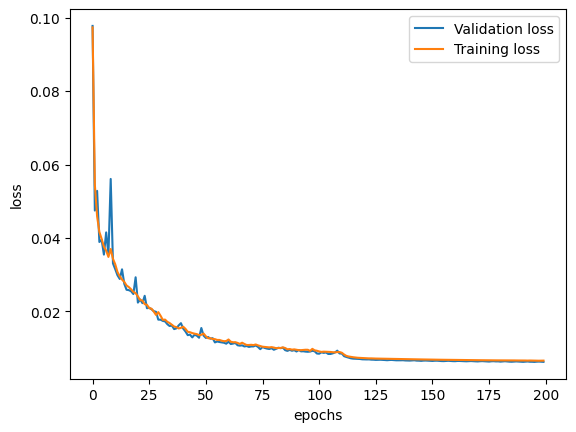

In [14]:
import matplotlib.pyplot as plt
plt.plot(all_val_loss)
plt.plot(all_train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [15]:
import os
import numpy as np
from PIL import Image

# From the best model

# model_weight_path = '/kaggle/input/transfuse_till_epoch_150/pytorch/default/1/best_model.pth'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = net.to(device)

# model.load_state_dict(torch.load(model_weight_path))
# print(model.load_state_dict(torch.load(model_weight_path)))

model.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/predicted_images/"
os.makedirs(output_dir, exist_ok=True)

# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        # outputs = get_ensemble_preds(predicted_masks)
        # Unpack the outputs if it's a tuple
        if isinstance(predicted_masks, tuple):
            map_x, map_1, map_2 = predicted_masks
            # Use the first output for predictions and loss
            outputs_for_pred = map_x
        else:
            outputs_for_pred = predicted_masks
            
        predicted_masks = torch.argmax(outputs_for_pred, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
test_dice = dice_coef(test_pred_msk,test_msk)
test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
test_iou = iou(test_pred_msk,test_msk)
test_voe = voe(test_pred_msk,test_msk)
test_rvd = rvd(test_pred_msk,test_msk)
      
# Print the loss for the current epoch
print(len(all_mask_names))
print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

Saved predicted masks in: /kaggle/outputs/predicted_images/
1414
test dice: 0.9089, test dice wo: 1.86324, test jaccard: 13.62446, test voe: 0.08391, test rvd: -0.03759


In [16]:
# after epoch 80
# test dice: 0.8998, test dice wo: 1.85836, test jaccard: 13.12033, test voe: 0.08969, test rvd: -0.03959

# after epoch 150
# test dice: 0.9045, test dice wo: 1.86275, test jaccard: 13.57189, test voe: 0.08505, test rvd: -0.03914

In [17]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        if union != 0:
            voe = (union - intersection) / union
        else:
            voe = 0  # If the union is zero, set VOE to zero (or some other default)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))

In [18]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())


Mean IoU = 0.8794832229614258
Dice Score = 0.9320321083068848
Relative Volume Difference (RVD) = 0.01774001680314541
Volume Overlap Error (VOE) = 0.120516836643219


In [19]:
# after epoch 80
# Mean IoU = 0.8696735501289368
# Dice Score = 0.9256469011306763
# Relative Volume Difference (RVD) = 0.025725968182086945
# Volume Overlap Error (VOE) = 0.1303265541791916

# after epoch 150
# Mean IoU = 0.8755816221237183
# Dice Score = 0.929437518119812
# Relative Volume Difference (RVD) = 0.0230131596326828
# Volume Overlap Error (VOE) = 0.12441838532686234

1414
00019PSFHSAoP4k_019.png
00019_PSFHAoP4k_mask.png
00027PSFHSAoP4k_027.png
00027_PSFHAoP4k_mask.png
00028PSFHSAoP4k_028.png
00028_PSFHAoP4k_mask.png
00031PSFHSAoP4k_031.png
00031_PSFHAoP4k_mask.png
00038PSFHSAoP4k_038.png
00038_PSFHAoP4k_mask.png


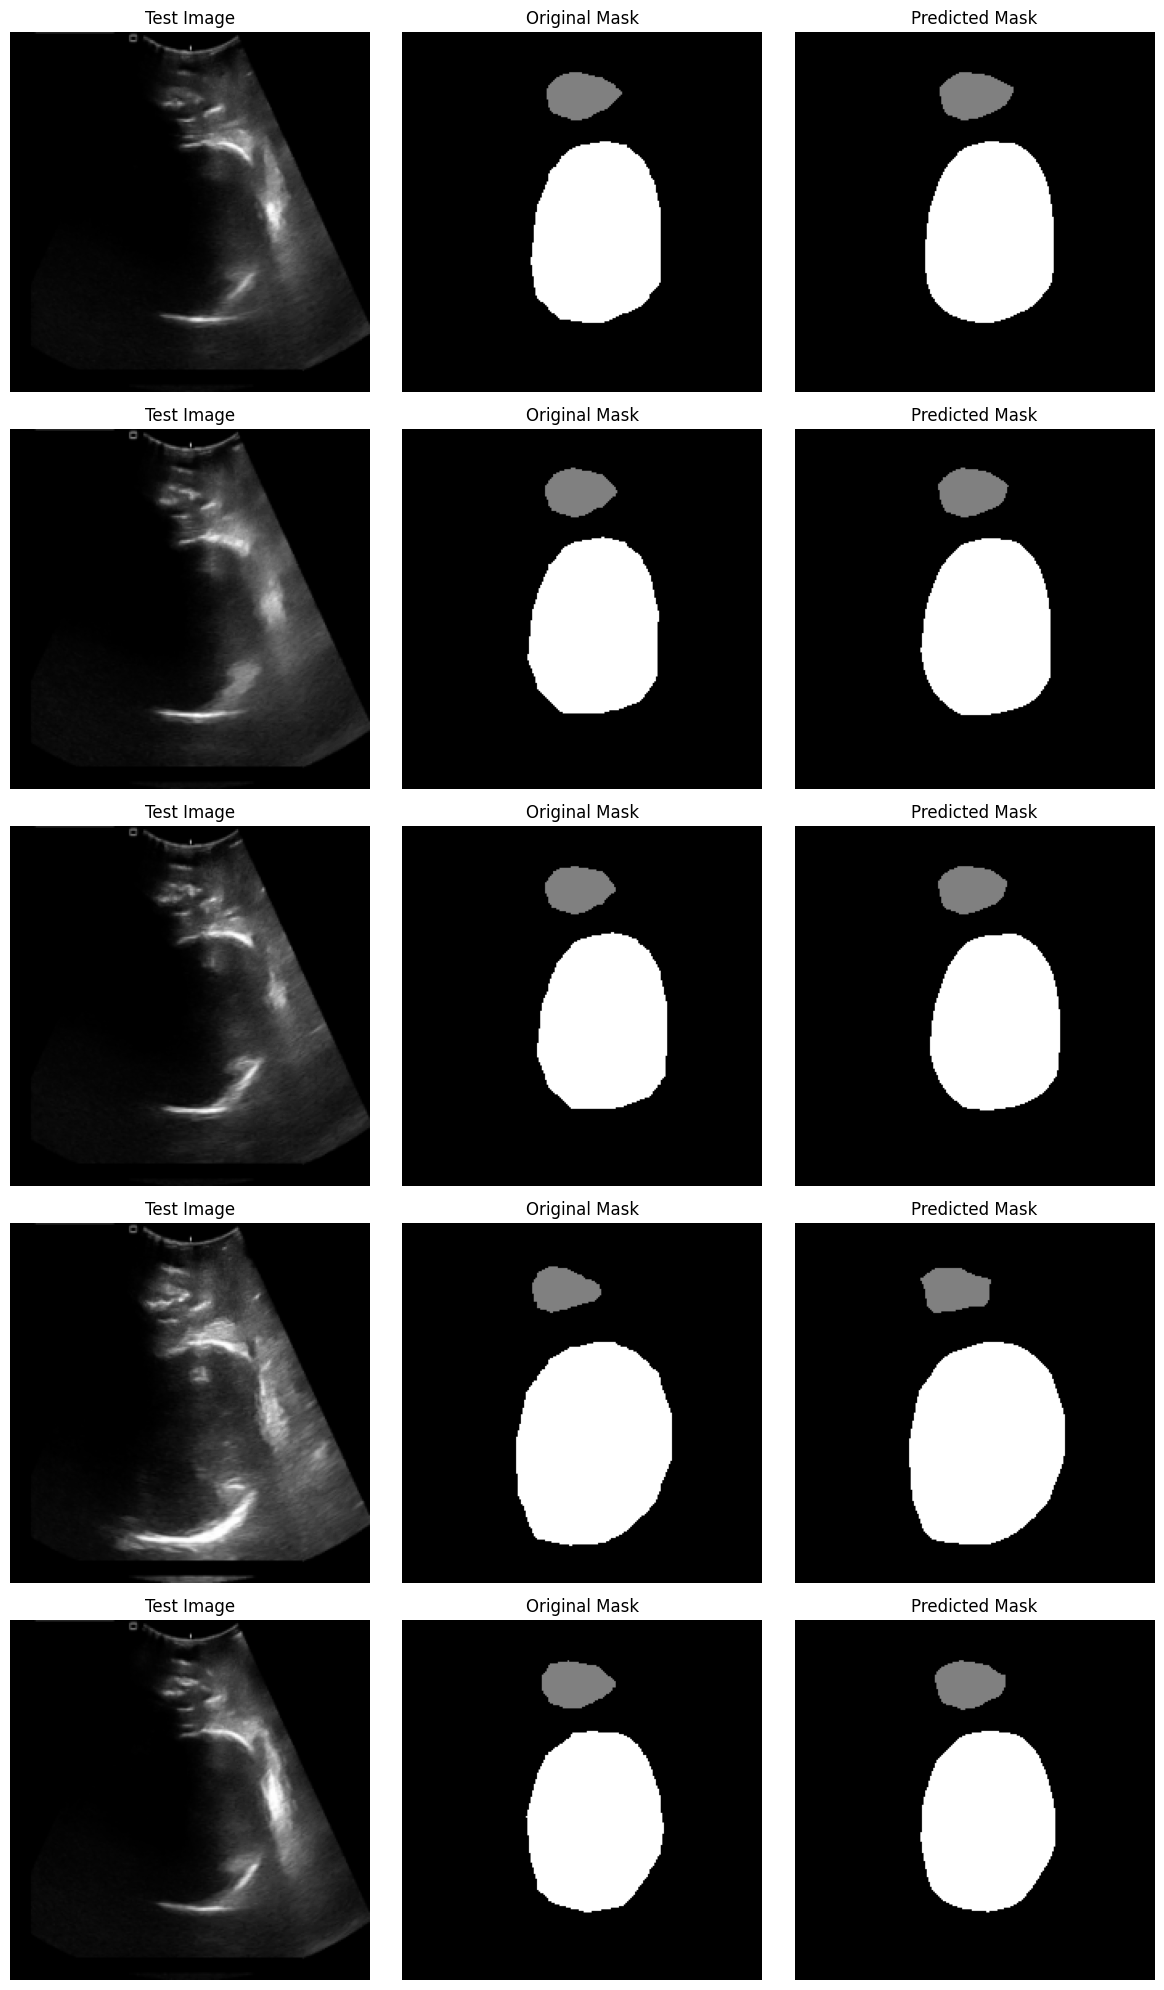

In [20]:
import cv2

test_img = np.array(test_img)
test_msk = np.array(test_msk)
test_pred_msk = np.array(test_pred_msk)

num_images = min(5, test_img.shape[0])  # Show up to 5 images
print(test_img.shape[0])

# Plot original image, ground truth mask, and predicted mask side by side
fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images * 4))

for i in range(num_images):
    print(all_image_names[i])
    print(all_mask_names[i])
    # Original Image
    axs[i, 0].imshow(test_img[i, 0], cmap='gray')  # Assuming grayscale images
    axs[i, 0].set_title("Test Image")
    axs[i, 0].axis("off")

    # Ground Truth Mask
    axs[i, 1].imshow(test_msk[i], cmap='gray')  # Ground truth masks with class labels
    axs[i, 1].set_title("Original Mask")
    axs[i, 1].axis("off")

    # Model-Predicted Mask
    axs[i, 2].imshow(test_pred_msk[i], cmap='gray')  # Predicted masks with class labels
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()